In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
cd /content/drive/My Drive/Colab Notebooks/TOPICS IN APPLIED STATISTICS1/5/data/cat-and-dog/my_cat_dog

/content/drive/My Drive/Colab Notebooks/TOPICS IN APPLIED STATISTICS1/5/data/cat-and-dog/my_cat_dog


In [0]:
import os
base_dir='/content/drive/My Drive/Colab Notebooks/TOPICS IN APPLIED STATISTICS1/5/data/cat-and-dog/my_cat_dog'#여기부터~
train_dir=os.path.join(base_dir,'train')
validation_dir=os.path.join(base_dir,'validation')
test_dir=os.path.join(base_dir,'test')  #여기까지 아래 프로그램 작성을 위해 5.2절에서 만든 path만 지정

In [91]:
#<과제>


from tensorflow.keras.applications import VGG16
vgg_base=VGG16(weights='imagenet',include_top=False, input_shape=(150,150,3))
vgg_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [92]:
# 1-3. 자료증대 + 이전학습 (fc층만 고정) 

# 위처럼 하는것보단, 아래처럼 하는게 일반적일듯.
# 위는 feature를 일일히 계산하기 위해 extract_features 함수를 만들어야 한다.
# 하지만, 이는 굉장히 불편해보임. 그래서 아래처럼 하는게 좋아보인다.
# 위처럼 하면 코딩하기도 불편함.


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
model_aug=Sequential()
model_aug.add(vgg_base) # 이렇게 이전의 모형도 들어올 수 있음.
model_aug.add(Flatten())
model_aug.add(Dense(128,activation='relu',kernel_regularizer=l2(0.001)))
model_aug.add(Dropout(0.5))
model_aug.add(Dense(1,activation='sigmoid'))
model_aug.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_14 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_27 (Dense)             (None, 128)               1048704   
_________________________________________________________________
dropout_13 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 129       
Total params: 15,763,521
Trainable params: 15,763,521
Non-trainable params: 0
_________________________________________________________________


In [93]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
train_datagen=ImageDataGenerator(rescale=1./255,rotation_range=20, width_shift_range=0.15,
                               height_shift_range=0.15,horizontal_flip=True)
validation_datagen=ImageDataGenerator(rescale=1./255) #검증데이터는 자료증대를 하지 않아야 함.
train_generator=train_datagen.flow_from_directory(train_dir,target_size=(150,150),
                                              batch_size=64, class_mode='binary')
validation_generator=train_datagen.flow_from_directory(validation_dir,target_size=(150,150),
                                              batch_size=64, class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [0]:
# 이제는, VGG16의 5번째 block 부터 train을 시키고 싶다.
# 출력층에 가까울수록 출력층에 입맛에 맞는 특성변수이기 때문에 마지막을 기준으로 점차 층을 올라가며 조절하게 된다.
# 이를 미세조정이라 부르며, deep한 부분을 고치는거임.


vgg_base.trainable=True # 전부 True로 바꾸고, 분류를 들어간다. 물론, 전부 False를주고, 이로부터 코드를 짤 수도있음.
trainable_layer=False #기본을 False라는 변수로 둠.

for layer in vgg_base.layers: #layers 라는 옵션 기억하기.
    if layer.name=='block5_conv1': # block5_conv1부터 trainable_layer가 True로 layer.trainable이 True로 바뀜
        trainable_layer=True
    if trainable_layer: #그래서, layer를 trainable하게 만드려면, 우리가 단순히 정의한 변수 trainable_layer를 가지고 정하게 됨.
        layer.trainable=True
    else:
        layer.trainable=False

In [0]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping('val_loss',mode='min',patience=3)
# ModelCheckpoint도 같이 써주면 좋다.

In [96]:
from tensorflow.keras import optimizers

model_aug.compile(optimizer=optimizers.RMSprop(lr=1e-5),loss='binary_crossentropy',metrics=['acc'])
result_final=model_aug.fit_generator(train_generator,steps_per_epoch=2000// 64  , epochs=30, validation_data=validation_generator,validation_steps=1000 // 64, callbacks=[early_stopping])

Epoch 1/30
31/31 [==============================] - 27s 865ms/step - loss: 0.9258 - acc: 0.6190 - val_loss: 0.7767 - val_acc: 0.7833
Epoch 2/30
31/31 [==============================] - 27s 856ms/step - loss: 0.7777 - acc: 0.7314 - val_loss: 0.6773 - val_acc: 0.8271
Epoch 3/30
31/31 [==============================] - 26s 850ms/step - loss: 0.6872 - acc: 0.8017 - val_loss: 0.6142 - val_acc: 0.8510
Epoch 4/30
31/31 [==============================] - 26s 847ms/step - loss: 0.6149 - acc: 0.8388 - val_loss: 0.5603 - val_acc: 0.8740
Epoch 5/30
31/31 [==============================] - 26s 843ms/step - loss: 0.5845 - acc: 0.8600 - val_loss: 0.5442 - val_acc: 0.8677
Epoch 6/30
31/31 [==============================] - 26s 842ms/step - loss: 0.5422 - acc: 0.8693 - val_loss: 0.5027 - val_acc: 0.8938
Epoch 7/30
31/31 [==============================] - 26s 844ms/step - loss: 0.5288 - acc: 0.8745 - val_loss: 0.5172 - val_acc: 0.8792
Epoch 8/30
31/31 [==============================] - 26s 845ms/step - 

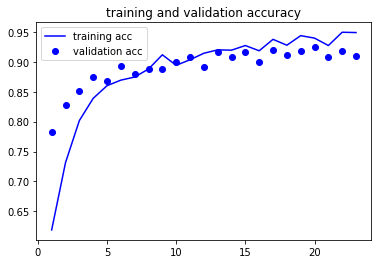

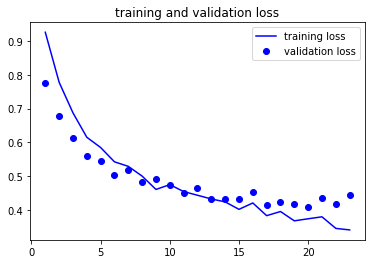

In [97]:
import matplotlib.pyplot as plt
acc=result_final.history['acc']
val_acc=result_final.history['val_acc']
loss=result_final.history['loss']
val_loss=result_final.history['val_loss']
epochs=range(1,len(acc)+1)
plt.plot(epochs,acc,'b',label='training acc')
plt.plot(epochs,val_acc,'bo',label='validation acc')
plt.title('training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs,loss,'b',label='training loss')
plt.plot(epochs,val_loss,'bo',label='validation loss')
plt.title('training and validation loss')
plt.legend()
plt.show()